In [ ]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install prophet
!pip install scikit-learn
!pip install plotly
!pip install neuralprophet[live]

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
from itertools import product
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import math
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from neuralprophet import NeuralProphet

plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [2]:
# 학습 데이터
data_tr = pd.read_csv('./t1_data_city/data_tr_city.csv')
data_tr

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0


In [3]:
# 평가 데이터
data_ts = pd.read_csv('./t1_data_city/data_ts_city.csv')
data_ts

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0
...,...,...
8419,2021-12-17 19:00:00,327.0
8420,2021-12-17 20:00:00,513.0
8421,2021-12-17 21:00:00,396.0
8422,2021-12-17 22:00:00,350.0


In [4]:
# 제출 양식
data_sample = pd.read_csv('./t1_data_city/sample_city.csv')
data_sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 복잡한 컬럼명 변경

In [5]:
data_tr.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_ts.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_tr.head()

,datetime,적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0


### 결측치 확인

In [6]:
data_tr[data_tr.적산차.isnull()]

,datetime,적산차
1748,2017-03-14 21:00:00,NaN
1982,2017-03-24 15:00:00,NaN
12716,2018-06-14 21:00:00,NaN
12717,2018-06-14 22:00:00,NaN
13187,2018-07-04 12:00:00,NaN
13234,2018-07-06 11:00:00,NaN
27253,2020-02-10 14:00:00,NaN
27254,2020-02-10 15:00:00,NaN


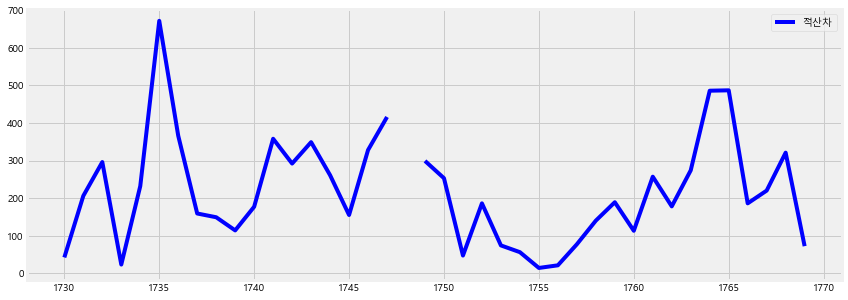

In [7]:
# 결측치 중 한 곳을 시각화
rcParams['figure.figsize'] = 13, 5
data_tr[1730:1770].plot(c='blue')
plt.show()

In [8]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')

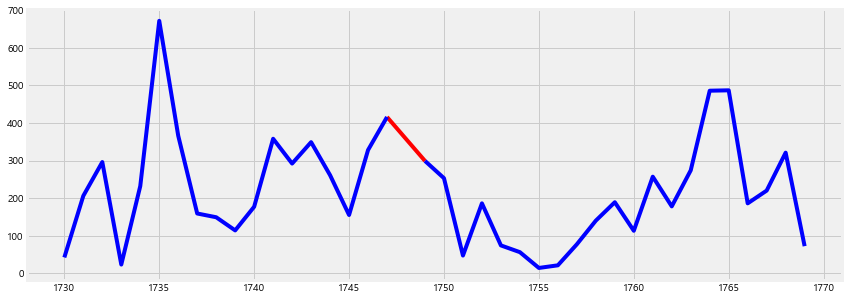

In [9]:
# 보간 후 데이터 시각화
data_tr_interpolate[1747:1750].적산차.plot(c='red')
data_tr[1730:1770].적산차.plot(c='blue')
plt.show()

data_tr = data_tr_interpolate

### 이상치 변환

#### 이상치 제거

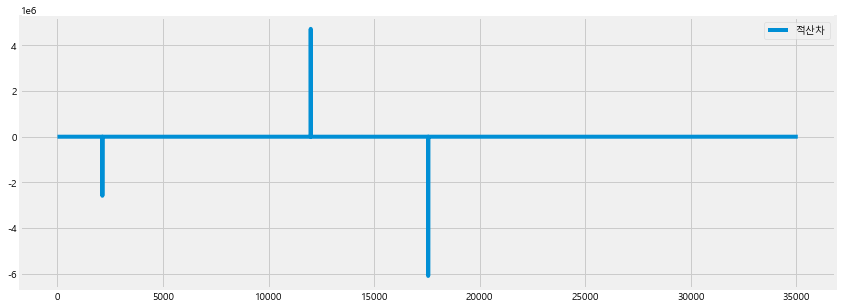

In [10]:
rcParams['figure.figsize'] = 13, 5
data_tr.plot()
plt.show()

In [11]:
index = data_tr[data_tr.적산차 == max(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([11995], dtype='int64')


In [12]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([17558], dtype='int64')


In [13]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([2127], dtype='int64')


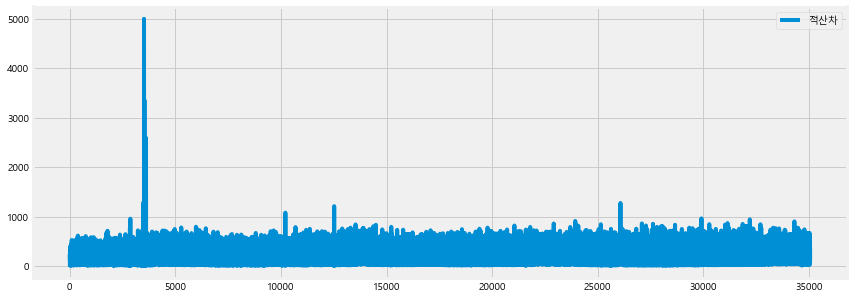

In [14]:
data_tr.plot()
plt.show()

In [15]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')
data_tr = data_tr_interpolate

In [16]:
data_tr.reset_index(drop=True, inplace=True)

In [17]:
data_tr['datetime'] = pd.to_datetime(data_tr['datetime'])
data_tr.set_index('datetime', inplace=True)

data_ts['datetime'] = pd.to_datetime(data_ts['datetime'])
data_ts.set_index('datetime', inplace=True)

data_tr

,적산차
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


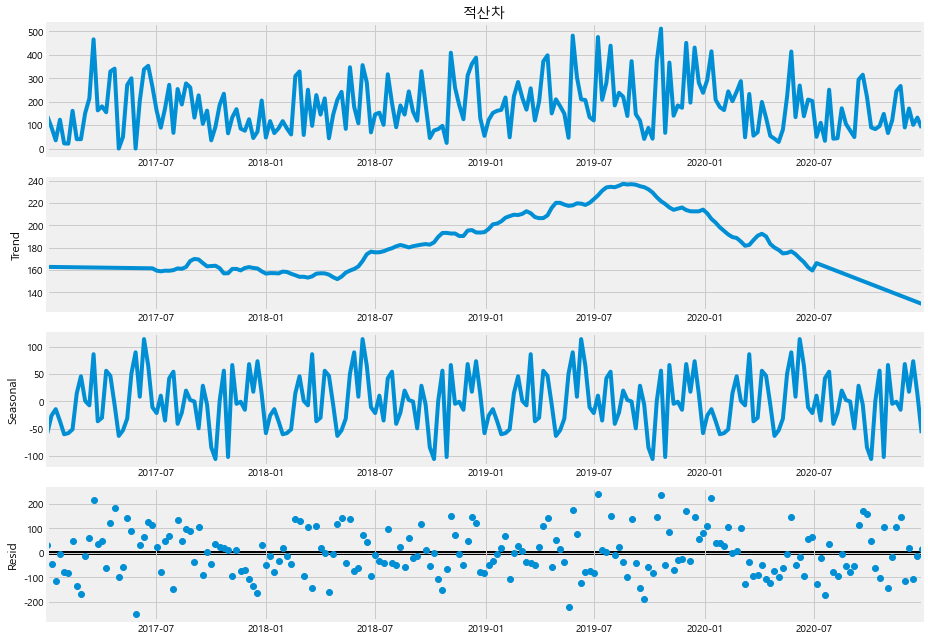

In [18]:
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'].asfreq('W'), extrapolate_trend='freq', period=52) # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

* 1년의 계절성을 지녔음

In [19]:
rainfall = pd.read_csv('./t1_data_city/rainfall_2017_2021.csv', encoding='cp949')
rainfall.head()

,datetime,강수량,1시간최다강수량,1시간최다강수량시각
0,2017-01-01,NaN,NaN,NaN
1,2017-01-02,NaN,NaN,NaN
2,2017-01-03,NaN,NaN,NaN
3,2017-01-04,NaN,NaN,NaN
4,2017-01-05,0.0,NaN,NaN


In [20]:
rainfall.datetime = pd.to_datetime(rainfall.datetime)
rainfall_hours = pd.DataFrame({'ds':[],
              '강수량':[],
              '1시간최다강수량':[],
              '1시간최다강수량시각':[]})

for i in range(len(rainfall)):    
    hours = pd.date_range(rainfall.datetime[i], rainfall.datetime[i] + datetime.timedelta(hours=23), freq='H')

    rainfall_temp = pd.DataFrame({'ds':hours,
                  '강수량':[rainfall['강수량'][i]] * 24,
                  '1시간최다강수량':[0] * 24,
                  '1시간최다강수량시각':[0] * 24})
    
    if str(rainfall['1시간최다강수량시각'][i]) != 'nan':
        max_time_rainfall = rainfall['1시간최다강수량시각'][i].split(':')[0]
        max_value_rainfall = rainfall['1시간최다강수량'][i]
        
        rainfall_temp.loc[max_time_rainfall, '1시간최다강수량시각'] = 1
        rainfall_temp.loc[max_time_rainfall, '1시간최다강수량'] = max_value_rainfall

    rainfall_hours = pd.concat([rainfall_hours, rainfall_temp], ignore_index=True)

rainfall_hours = rainfall_hours[1:]
rainfall_hours.fillna(0, inplace=True)
rainfall_hours.reset_index(drop=True, inplace=True)
rainfall_hours

,ds,강수량,1시간최다강수량,1시간최다강수량시각
0,2017-01-01 01:00:00,0.0,0.0,0.0
1,2017-01-01 02:00:00,0.0,0.0,0.0
2,2017-01-01 03:00:00,0.0,0.0,0.0
3,2017-01-01 04:00:00,0.0,0.0,0.0
4,2017-01-01 05:00:00,0.0,0.0,0.0
...,...,...,...,...
44109,2021-12-31 19:00:00,0.0,0.0,0.0
44110,2021-12-31 20:00:00,0.0,0.0,0.0
44111,2021-12-31 21:00:00,0.0,0.0,0.0
44112,2021-12-31 22:00:00,0.0,0.0,0.0


In [21]:
data_tr_rainfall = rainfall_hours[:35063]
data_ts_rainfall = rainfall_hours[35063:43487]
print(len(data_tr), len(data_ts))
print(len(data_tr_rainfall), len(data_ts_rainfall))

35063 8424
35063 8424


In [24]:
meanperhour = []

for i in tqdm(range(24)):
    ytemp = []
    for j in range(len(data_tr)):
        hour = int(str(data_tr.index[j]).split()[1][:2])
        if i == j:
            ytemp.append(data_tr.적산차[i])
    meanperhour.append(np.mean(ytemp))
print(meanperhour)

100%|██████████| 24/24 [00:06<00:00,  3.85it/s]

[138.0, 237.0, 128.0, 14.0, 11.0, 10.0, 11.0, 187.0, 392.0, 114.0, 243.0, 203.0, 250.0, 181.0, 141.0, 148.0, 132.0, 199.0, 202.0, 245.0, 308.0, 152.0, 197.0, 175.0]


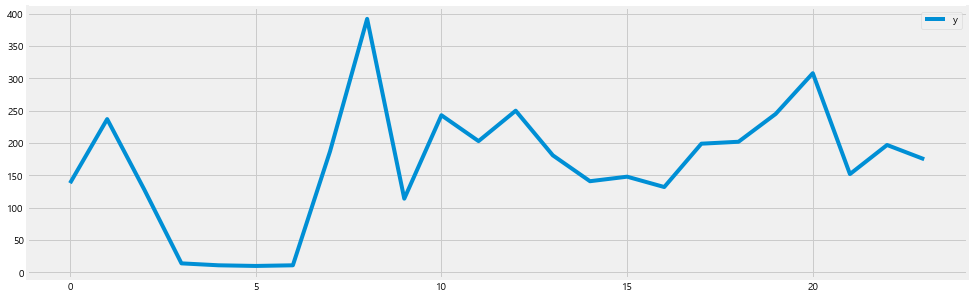

In [25]:
rcParams['figure.figsize'] = 15, 5
pd.DataFrame({'y':meanperhour}).plot()
plt.show()

## Neural Prophet

* 스탠포드 대학교와 메타가 PyTorch를 활용하여 개발하여 기존 prophet 모델에서 개선된 딥러닝 모델

In [33]:
data_tr_prophet = data_tr.copy()
data_tr_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_tr_prophet['ds'] = data_tr_prophet.index
data_tr_prophet.reset_index(drop=True, inplace=True)

data_ts_prophet = data_ts.copy()
data_ts_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_ts_prophet['ds'] = data_ts_prophet.index
data_ts_prophet.reset_index(drop=True, inplace=True)

In [125]:
yearly_seasonality = [False, 5, 10, 20]
weekly_seasonality = [False, 5, 10, 20]
daily_seasonality = [False, 5, 10, 20]
n_changepoints = [10, 20, 50,] # 300, 500도 해보기 # 높은게 좋은듯
num_hidden_layers = [2, 3, 5]
d_hidden = [24, 48, 128, 256, 1200]

nprophet_params = [(x[0], x[1], x[2], x[3], x[4], x[5]) 
                   for x in list(product(yearly_seasonality,
                                weekly_seasonality,
                                daily_seasonality,
                                n_changepoints,
                                num_hidden_layers,
                                d_hidden))]

best_mae, cnt = '', 0

for ys, ws, ds, nc, nhl, dh in tqdm(nprophet_params):
    m = NeuralProphet(
        seasonality_mode='multiplicative',
        changepoints_range=0.95,
        #growth='decontinuous', #off, leaner, decontinuous
        yearly_seasonality=ys,
        weekly_seasonality=ws,
        daily_seasonality=ds,
        n_changepoints=nc,
        seasonality_reg=1,
        ar_reg=1,
        num_hidden_layers=nhl, # 은닉층 수
        d_hidden=dh, # 은닉층 차원 수
        learning_rate=0.1,
        epochs=100
    )
    
    metrics = m.fit(data_tr_train, validation_df=data_ts_prophet, freq='H')

    forecast = m.predict(data_ts_prophet)
    
    mae = metrics.MAE.tail(1).item()
    
    if cnt == 0:
        cnt += 1
        best_mae = mae
        
    if best_mae > mae:
        best_mae = mae
        best_param = [ys, ws, ds, nc, nhl, dh]
    
    clear_output()
    
    print(f'ys={ys}, ws={ws}, ds={ds}, hps={hps}, sps={sps}, nc={nc}, nhl={nhl}, dh={dh}, mae={mae}, best mae={best_mae}')

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.996% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


ys=False, ws=False, ds=False, hps=0.01, sps=0.01, nc=10, nhl=2, dh=48, mae=129.1732338285927, best mae=129.1732338285927


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64

Epoch[15/100]:  15%|█▌        | 15/100 [00:09<00:51,  1.64it/s, SmoothL1Loss=0.047, MAE=130, RMSE=161, Loss=0.036, RegLoss=0, MAE_val=152, RMSE_val=198, SmoothL1Loss_val=0.0725]


Epoch[18/100]:  18%|█▊        | 18/100 [00:11<00:50,  1.62it/s, SmoothL1Loss=0.0472, MAE=130, RMSE=161, Loss=0.0361, RegLoss=0, MAE_val=155, RMSE_val=202, SmoothL1Loss_val=0.0754]

KeyboardInterrupt



126.02537953366807


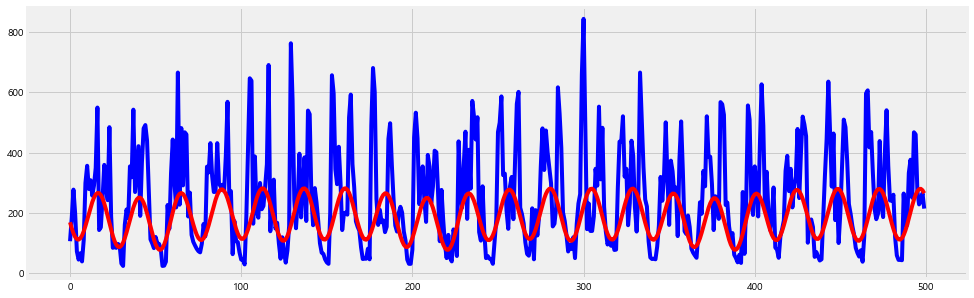

In [107]:
mae = mean_absolute_error(forecast['yhat1'], forecast['y'])
print(mae)

forecast[:500].y.plot(c='blue')
forecast[:500].yhat1.plot(c='red')
plt.show()

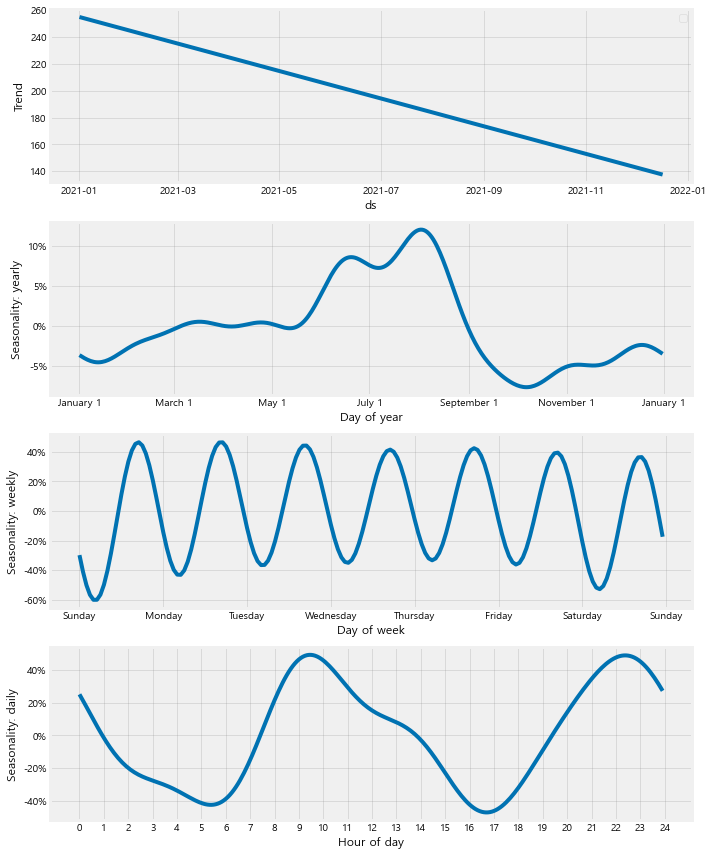

In [78]:
fig_comp = m.plot_components(forecast)

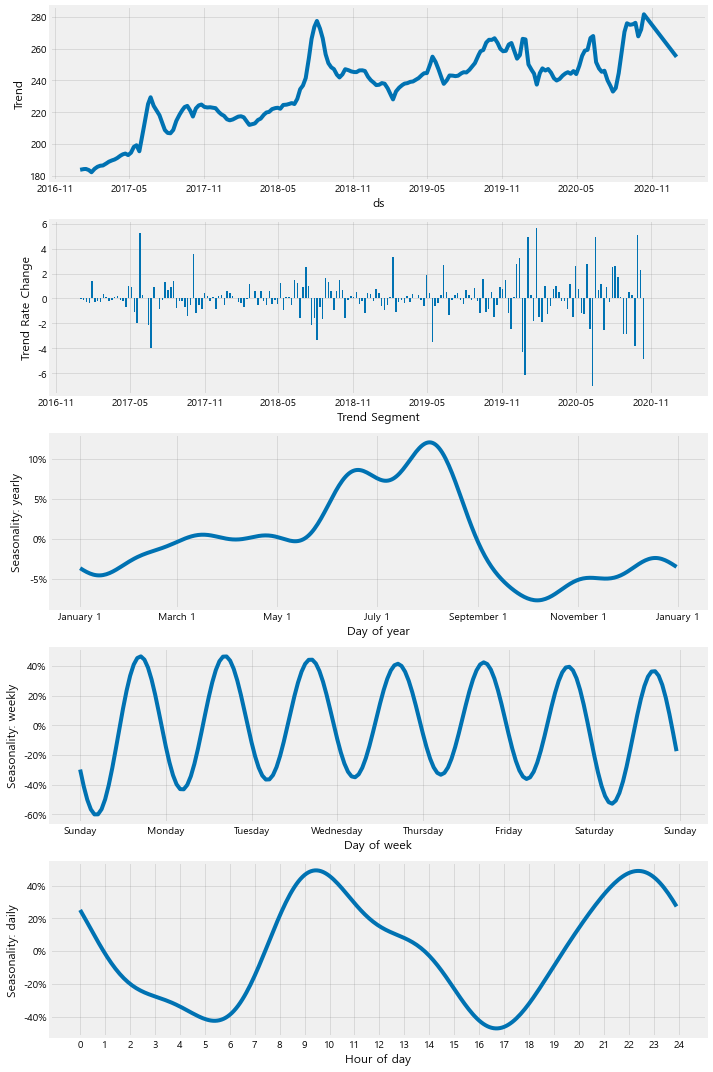

In [79]:
fig_param = m.plot_parameters()

In [52]:
for i, start in enumerate(tqdm(data_sample.datetime)):
    
    start = pd.to_datetime(start)
    ds = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')

    future = pd.DataFrame({'ds':ds,
                            'y':[np.NaN]*336})
    forecast = m.predict(future)
    data_sample.loc[i] = [start] + list(forecast['yhat1'])

    clear_output()
    
data_sample

  0%|          | 0/8425 [00:00<?, ?it/s]INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.702% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.702% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
  0%|          | 0/8425 [00:00<?, ?it/s]


ValueError: Dataframe column 'y' only has NaN rows.

In [43]:
data_sample.to_csv('./t1_data_city/submission_neuralprophet.csv', index=False)